In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from functools import partial

import xgboost as xgb
from sklearn import preprocessing
from scipy.optimize import minimize

pd.set_option('display.max_columns', None)

# custom modules
from preproc import load_data,scale_data
#from calibration1 import calibrate_probs,optimize_calibration
from calibration2 import calibrate_probs,optimize_calibration

***
## loading data

In [2]:
train,test,input_cols = load_data()

display(train)
display(test)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
train,test,scaler = scale_data(train, test, input_cols)

display(train)
display(test)
scaler

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.033981,0.108373,0.044605,0.035517,0.045482,0.018287,0.002479,0.251779,0.003796,0.077771,0.771084,0.071753,0.443088,0.004597,0.005139,0.020790,0.137333,0.036916,0.024143,0.104796,0.033143,0.022774,0.051444,0.262953,0.561145,0.328451,0.140520,0.006298,0.268041,0.085063,0.258453,0.472186,0.032913,0.069189,0.152195,0.076814,0.108447,0.047387,0.022295,1.0,0.282973,0.073832,0.000589,0.004420,0.006502,0.063036,0.099954,0.052911,0.001397,0.003023,0.083510,0.048493,0.013936,0.272577,0.365256,0.005476,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.023578,0.034117,0.044605,0.058633,0.045482,0.094907,0.002479,0.346863,0.000840,0.103597,0.662651,0.063677,0.042811,0.000286,0.005139,0.013333,0.118135,0.079914,0.030279,0.140320,0.035151,0.367737,0.105660,0.274095,0.580837,0.336605,0.084888,0.006298,0.342784,0.105400,0.232180,0.597566,0.000034,0.069189,0.113041,0.051879,0.046854,0.036744,0.000071,0.0,1.000000,0.089710,0.008039,0.005667,0.000188,0.047373,0.288944,0.001256,0.000399,0.018139,0.068439,0.048493,0.194600,0.358763,0.168059,1.000000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.076283,0.091853,0.044605,0.051324,0.045482,0.175926,0.002479,0.329075,0.000840,0.096791,0.903614,0.052695,0.636367,0.002690,0.005139,0.014336,0.120850,0.135676,0.026753,0.161634,0.033143,0.230403,0.146915,0.203900,0.332596,0.336706,0.152813,0.006298,0.198454,0.114430,0.200682,0.446654,0.007993,0.069189,0.241944,0.082285,0.444567,0.049401,0.008861,1.0,1.000000,0.073832,0.000829,0.073980,0.005540,0.058223,0.324312,0.055894,0.000784,0.038221,0.273070,0.059177,0.095118,0.345063,0.184067,0.008961,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.040915,0.133144,0.062929,0.122300,0.045482,0.096296,0.002479,0.283635,0.000840,0.078583,0.807229,0.096937,0.032063,0.003690,0.005139,0.006693,0.174964,0.139155,0.011682,0.129663,0.044190,0.209258,0.153454,0.145961,0.333693,0.224769,0.093471,0.006298,0.275773,0.133272,0.219385,0.387766,0.016457,0.069189,0.341333,0.077782,0.208095,0.518836,0.014435,1.0,0.290257,0.073832,0.004818,0.019567,0.004994,0.076563,0.414270,0.044385,0.000399,0.009069,0.136466,0.055042,0.014565,0.491913,0.473304,0.007090,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.061720,0.130125,0.044605,0.022368,0.045482,0.103009,0.005313,0.087160,0.069791,0.107966,0.819277,0.132586,0.434411,0.033890,0.005139,0.036194,0.130749,0.114665,0.151954,0.113677,0.033143,0.228034,0.118401,0.167131,0.533393,0.352137,0.095169,0.006298,0.195876,0.093331,0.161965,0.414276,0.007096,0.069189,0.059498,0.077410,0.190497,0.046411,0.003859,1.0,1.000000,0.086494,0.007866,0.009603,0.002708,0.113095,0.381209,0.059109,0.038981,0.003887,0.120847,0.097579,0.059283,0.558809,0.189663,0.004396,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.024272,0.109106,0.064794,0.015089,0.072765,0.091435,0.007497,0.219276,0.001916,0.078357,0.722892,0.068583,0.079176,0.002039,0.005139,0.018213,0.168475,0.087072,0.023787,0.062167,0.037160,0.229712,0.149882,0.216156,0.108966,0.103451,0.169217,0.006298,0.420103,0.168684,0.278689,0.445133,0.000034,0.096021,0.213374,0.084406,0.073911,0.016370,0.000071,0.0,0.473026,0.073832,0.010124,0.009803,0.000188,0.119862,0.275565,0.001256,0.001013,0.002159,0.066041,0.145022,0.056304,0.303414,0.361892,1.000000,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
613,fd895603f071,0.070735,0.190393,

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MaxAbsScaler())])

In [4]:
repeated_cv_split = joblib.load("/kaggle/input/iarc-data-split/repeated_5fold_cv_split_4validation.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [5]:
def balanced_logloss_(y_pred, y_true, eps=1e-7):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, eps, 1-eps)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / (n0+eps)
    log_loss1 = - np.sum(y_true * np.log(p1)) / (n1+eps)
    return (log_loss0 + log_loss1)/2

In [6]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [7]:
model_params = {
    'booster': 'gblinear',
    'objective': 'binary:logistic',
    'verbosity': 2,
    'seed': 2112,
    'eta': 0.005,
    'alpha': 0.0002916325484528911,
    'feature_selector': 'cyclic',
    'lambda': 1.2335024807220584e-09,
    'num_iterations': 1998,
    'scale_pos_weight': 4.712962962962963,
    'updater': 'shotgun'
}

In [8]:
VERBOSE = True

models = list()
metrics = list()
oof_dfs = list()

for repeat in range(REPETITIONS):
    print(f"REPEAT NUMBER: {repeat+1}/{REPETITIONS}")
    cv_split = repeated_cv_split[f"repeat_{repeat}"]
    n_folds = len(cv_split)
    
    oof = train[["Id","Class"]].copy()
    oof["pred_proba"] = np.nan
    
    for split in cv_split:
        fold = split["fold"]
        train_idx = split["train_idx"]
        valid_idx = split["valid_idx"]
        print(f"training model for fold: {fold+1}/{n_folds}")
    
        train_df = train.loc[train_idx,:].reset_index(drop=True)
        valid_df = train.loc[valid_idx,:].reset_index(drop=True)
        
        _model_params = dict(model_params)
        num_iterations = _model_params.pop('num_iterations')

        train_dset = xgb.DMatrix(
            data=train_df.loc[:,input_cols],
            label=train_df.loc[:,"Class"].values,
        )
        model = xgb.train(
            params=_model_params,
            dtrain=train_dset,
            num_boost_round=num_iterations,
        )
        
        y_pred = model.predict(xgb.DMatrix(valid_df.loc[:,input_cols]))
        valid_loss = balanced_logloss_(y_pred, valid_df.loc[:,"Class"].values)
        oof.loc[valid_idx, "pred_proba"] = y_pred
        
        models.append(model)
        metrics.append(valid_loss)
        
    oof_dfs.append(oof)

REPEAT NUMBER: 1/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUMBER: 2/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUMBER: 3/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUMBER: 4/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUMBER: 5/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUMBER: 6/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUM

***
## OOF analysis and calibration

In [9]:
oof_scores = oof_dfs[0].copy()
oof_scores.rename({"pred_proba":"pred_proba0"}, axis=1, inplace=True)

for i in range(1, len(oof_dfs)):
    _df = oof_dfs[i].copy()
    _df.rename({"pred_proba":f"pred_proba{i}"}, axis=1, inplace=True)
    oof_scores = oof_scores.merge(_df, on=["Id","Class"])
    
oof_scores["avg_proba"] = oof_scores.iloc[:,2:].mean(axis=1)
oof_scores

,Id,Class,pred_proba0,pred_proba1,pred_proba2,pred_proba3,pred_proba4,pred_proba5,pred_proba6,pred_proba7,pred_proba8,pred_proba9,avg_proba
0,000ff2bfdfe9,1,0.815806,0.918628,0.888052,0.910814,0.897658,0.852911,0.886268,0.862416,0.867966,0.913901,0.881442
1,007255e47698,0,0.017977,0.015485,0.028003,0.029167,0.031967,0.017960,0.031072,0.017206,0.040527,0.027815,0.025718
2,013f2bd269f5,0,0.281990,0.280563,0.307836,0.363577,0.448202,0.410894,0.394127,0.342741,0.339348,0.287400,0.345668
3,043ac50845d5,0,0.090100,0.104951,0.119172,0.143084,0.098019,0.107674,0.112376,0.092960,0.211424,0.192601,0.127236
4,044fb8a146ec,1,0.728934,0.773060,0.518634,0.795441,0.833506,0.623493,0.830746,0.619290,0.556632,0.785251,0.706499
...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0,0.097993,0.180515,0.207878,0.197445,0.182462,0.167777,0.209849,0.172340,0.207314,0.054996,0.167857
613,fd895603f071,0,0.436032,0.274249,0.475510,0.512430,0.551286,0.172149,0.293489,0.413004,0.215202,0.458288,0.380164
614,fd8ef6377f76,0,0.136181,0.105456,0.060301,0.048316,0.053618,0.081675,0.088567,0.073485,0.055268,0.051480,0.075435
615,fe1942975e40,0,0.194934,0.127733,0.205872,0.182925,0.164719,0.127869,0.173221,0.151485,0.203381,0.159150,0.169129


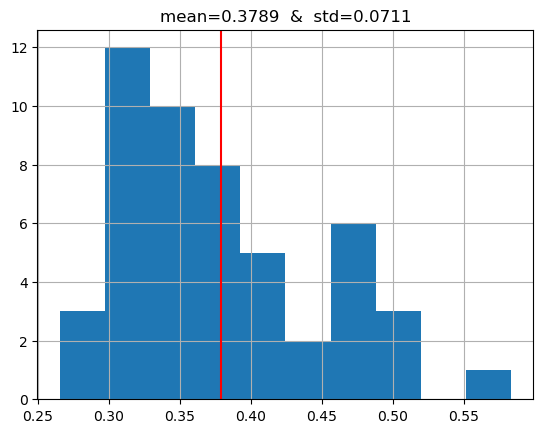

In [10]:
_metrics = metrics[:50]

metric_mean = np.mean(_metrics)
metric_median = np.median(_metrics)
metric_std = np.std(_metrics)

plt.hist(_metrics, bins=10)
plt.axvline(metric_mean, c="r")
plt.title(f"mean={metric_mean:0.4f}  &  std={metric_std:0.4f}")
plt.grid()
plt.show()

In [11]:
calib_params = optimize_calibration(oof_dfs)

best_value: 0.36502436920847003
best_params: {'alpha': 2.0278783798344606, 'beta': 1.365737658029456, 'gamma': 0.6710854934021836}


####################################################################################################
CV repeat nbr: 1 - metric: 0.3660


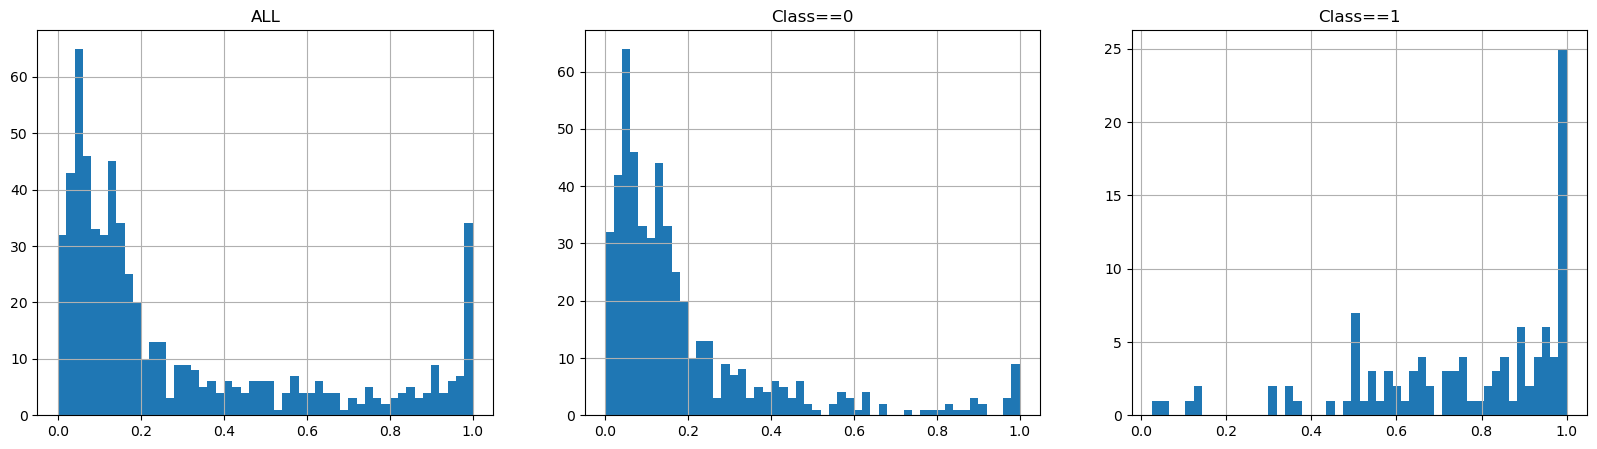

CV repeat nbr: 1 - metric: 0.3464


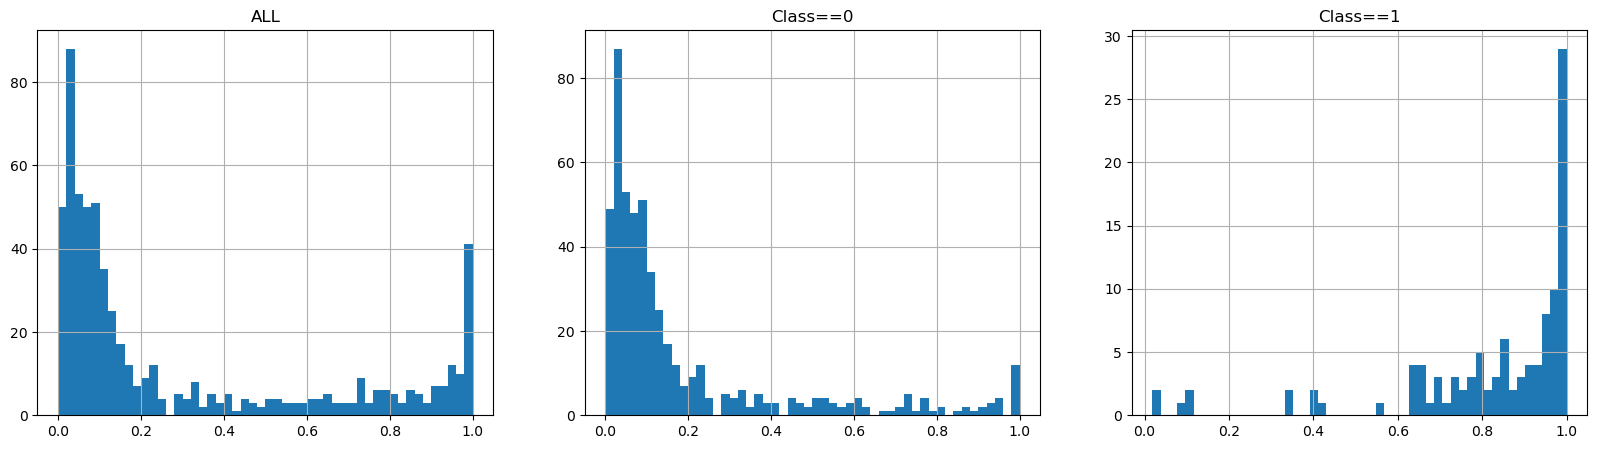

####################################################################################################
CV repeat nbr: 2 - metric: 0.3807


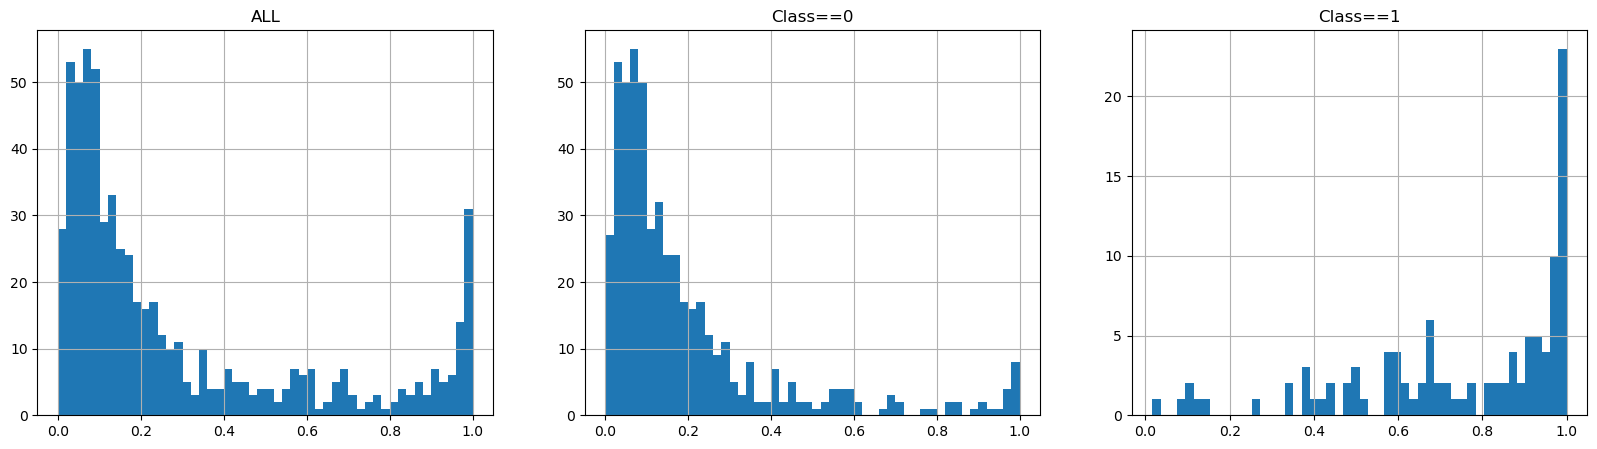

CV repeat nbr: 2 - metric: 0.3653


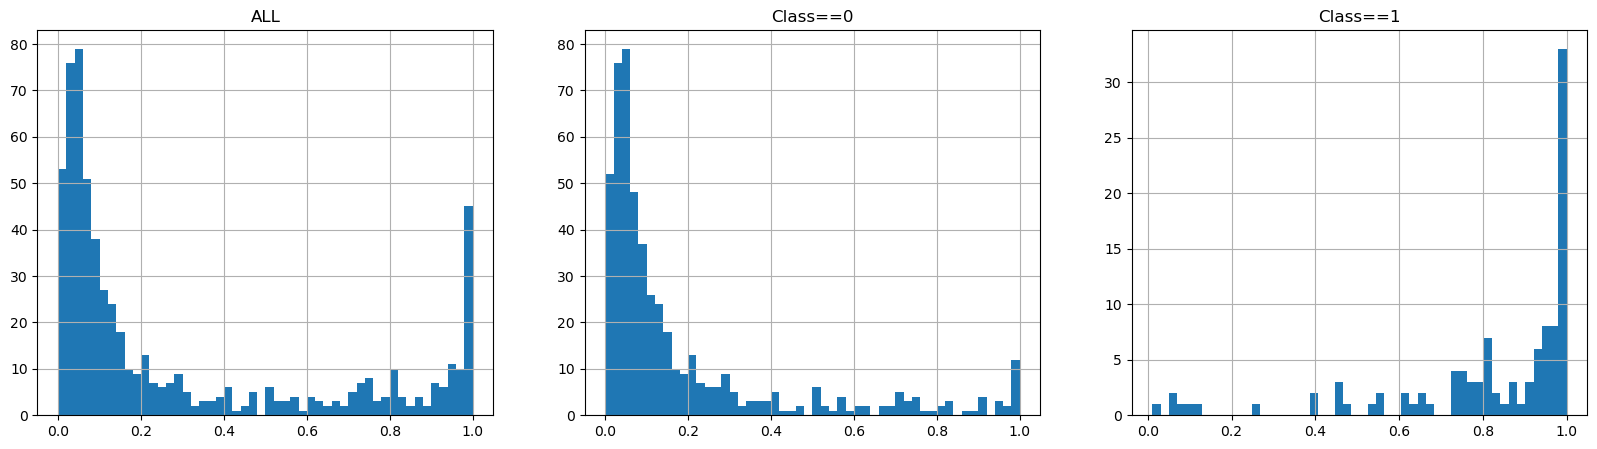

####################################################################################################
CV repeat nbr: 3 - metric: 0.3810


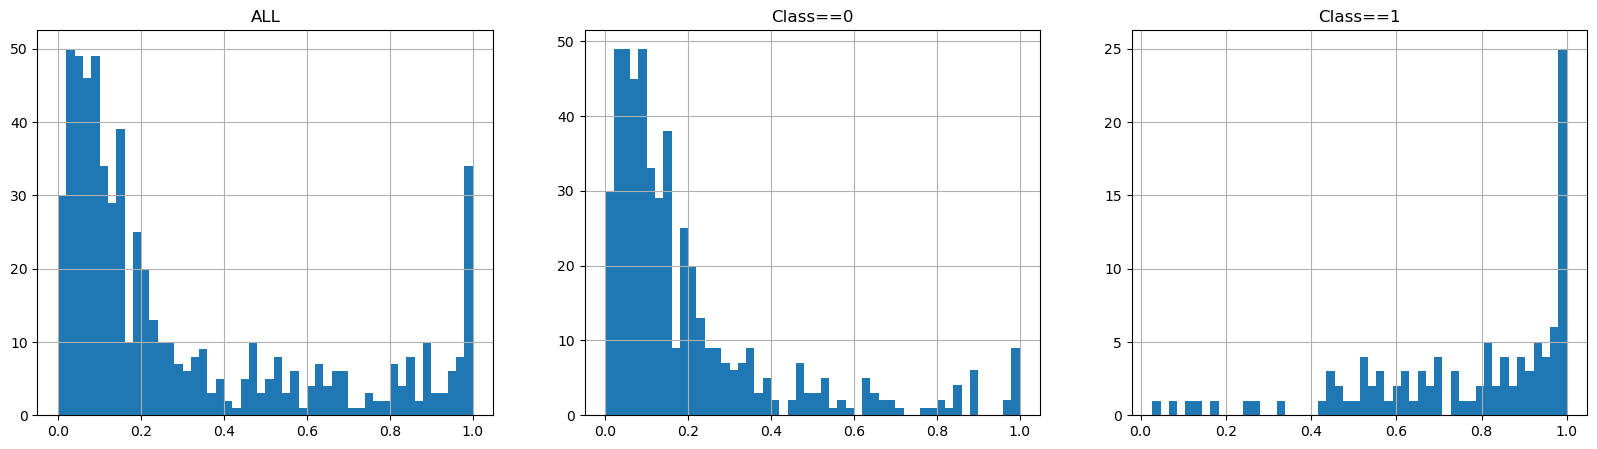

CV repeat nbr: 3 - metric: 0.3658


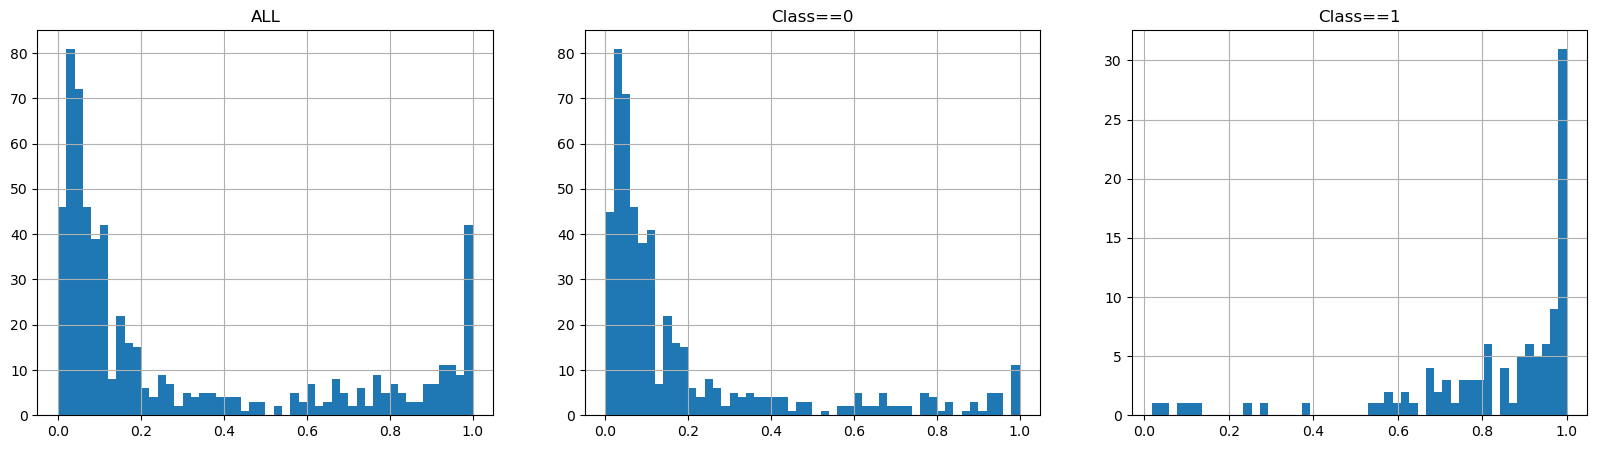

####################################################################################################
CV repeat nbr: 4 - metric: 0.4002


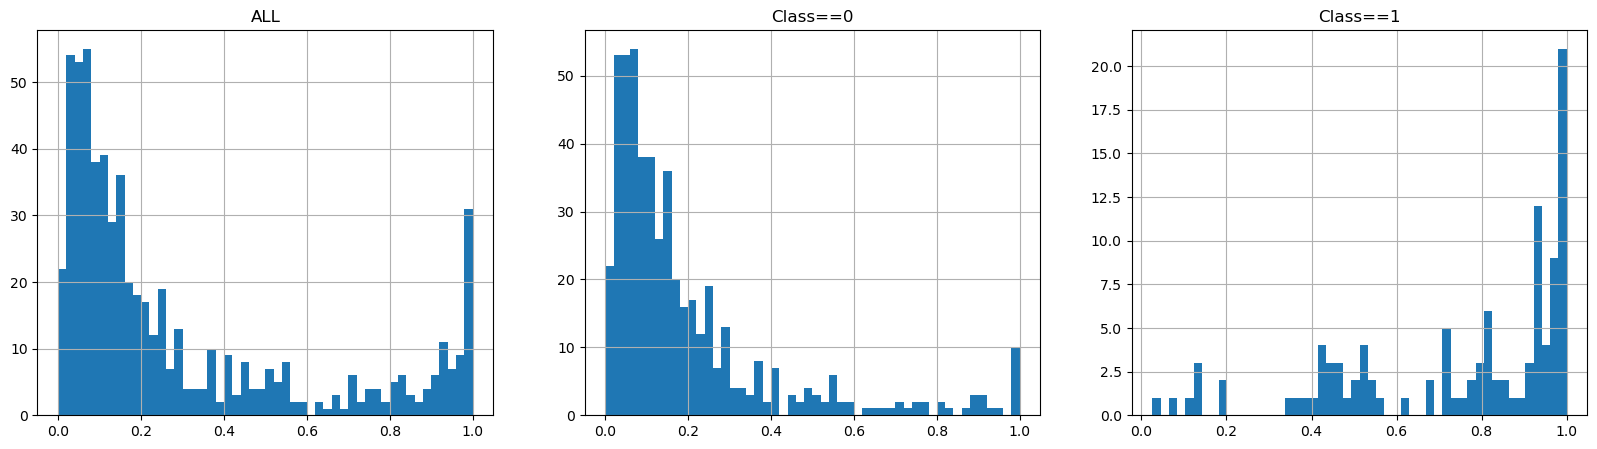

CV repeat nbr: 4 - metric: 0.3890


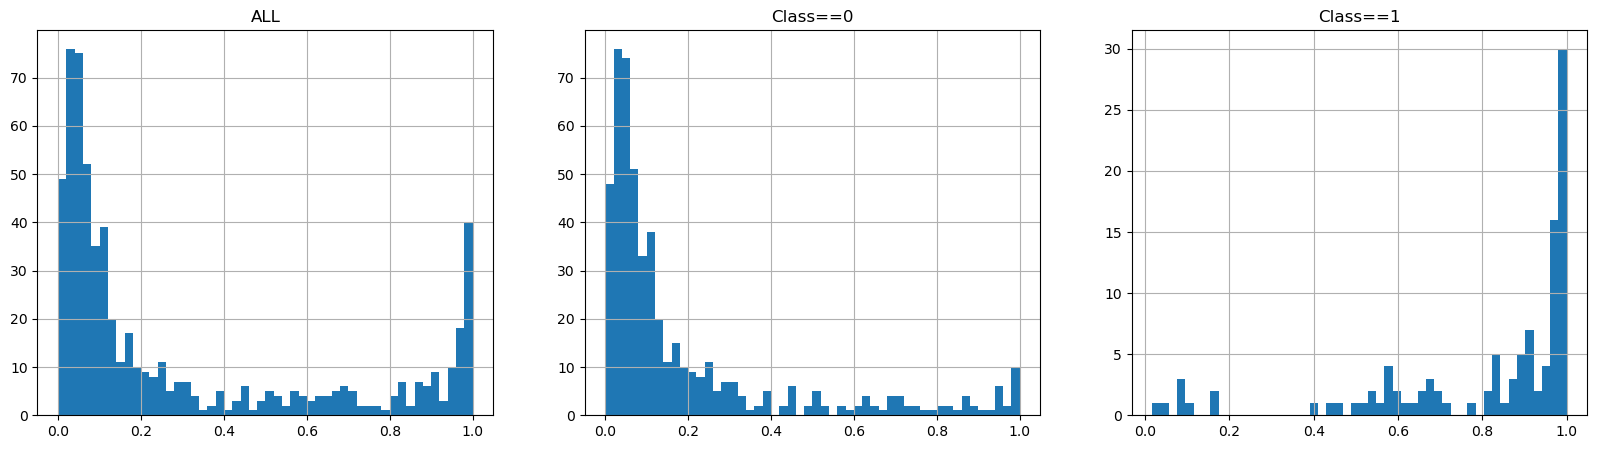

####################################################################################################
CV repeat nbr: 5 - metric: 0.3556


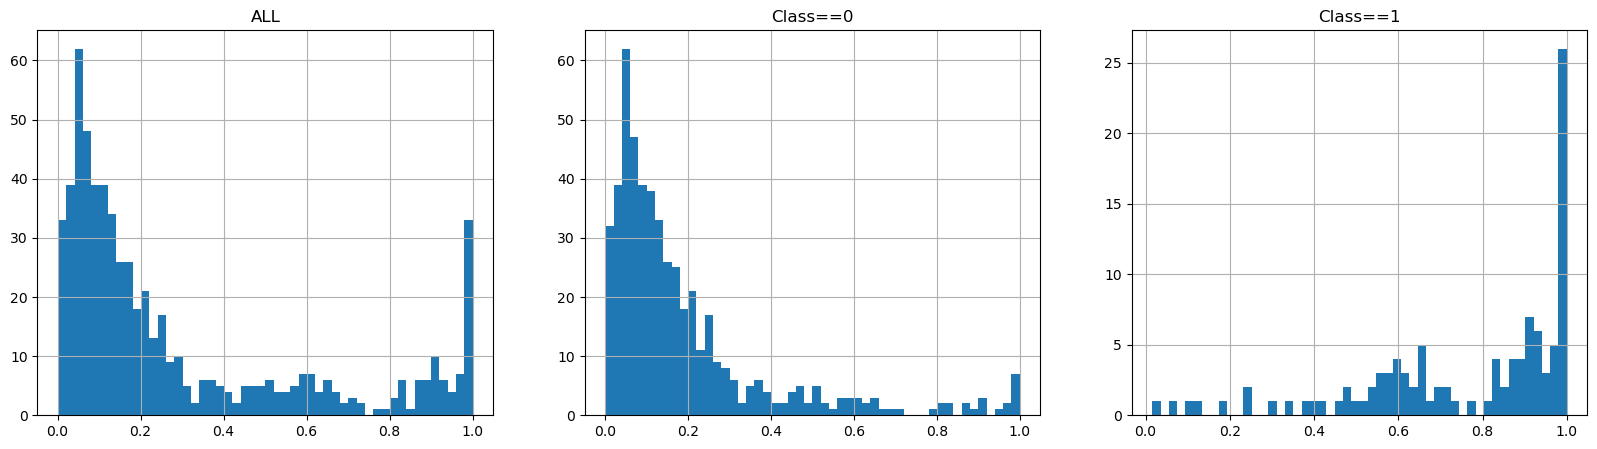

CV repeat nbr: 5 - metric: 0.3385


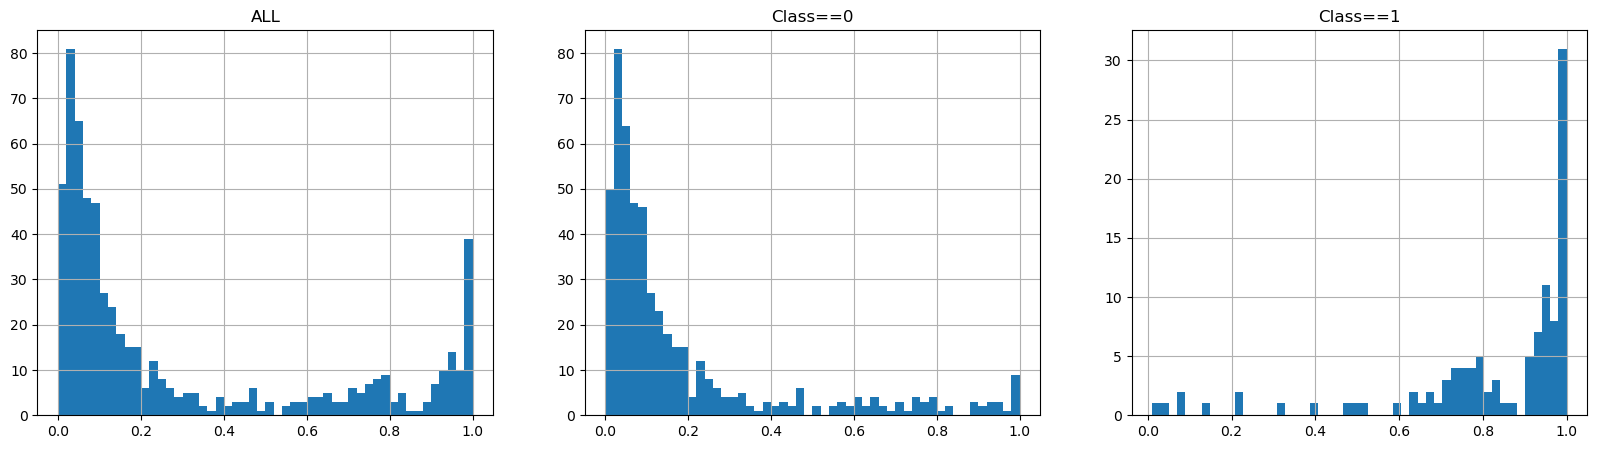

####################################################################################################
CV repeat nbr: 6 - metric: 0.3972


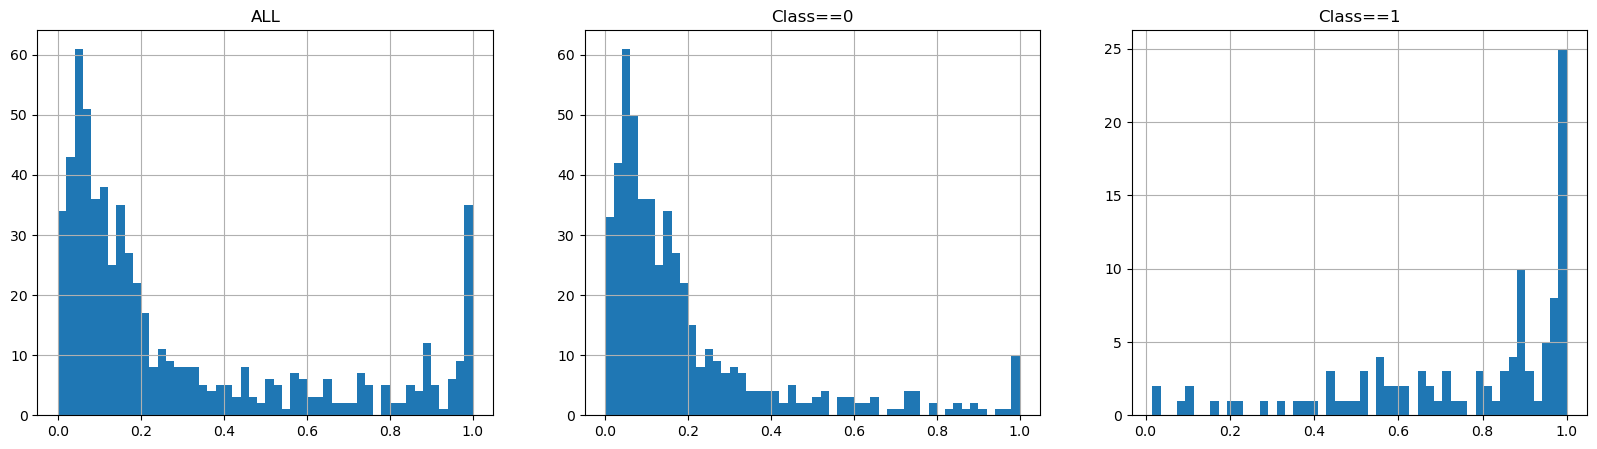

CV repeat nbr: 6 - metric: 0.3888


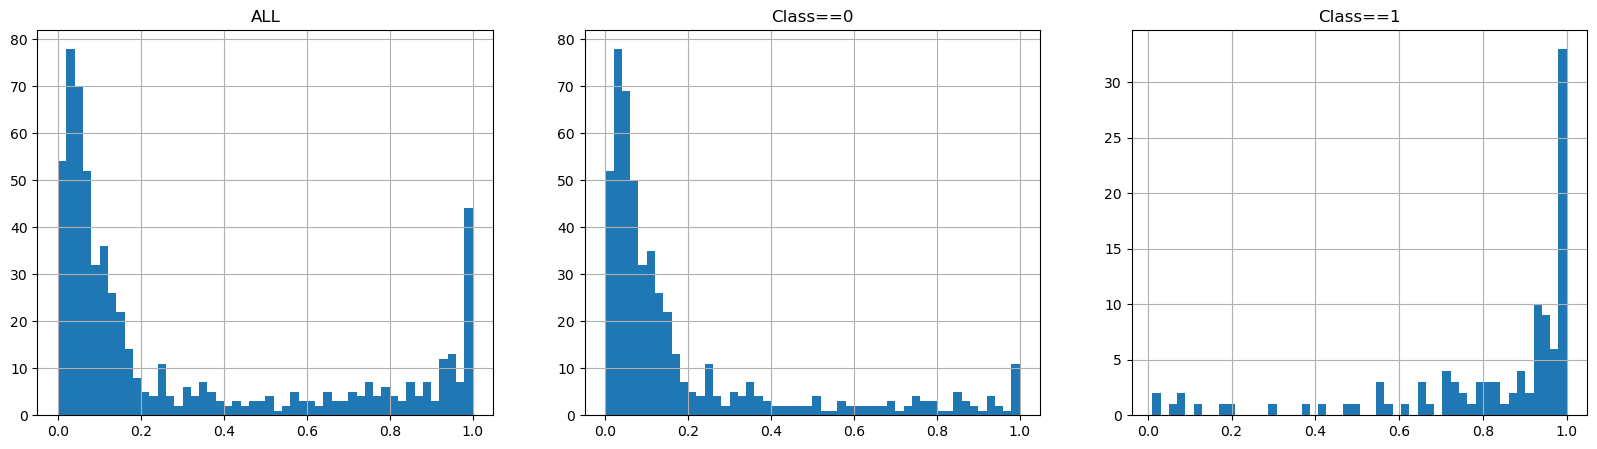

####################################################################################################
CV repeat nbr: 7 - metric: 0.3688


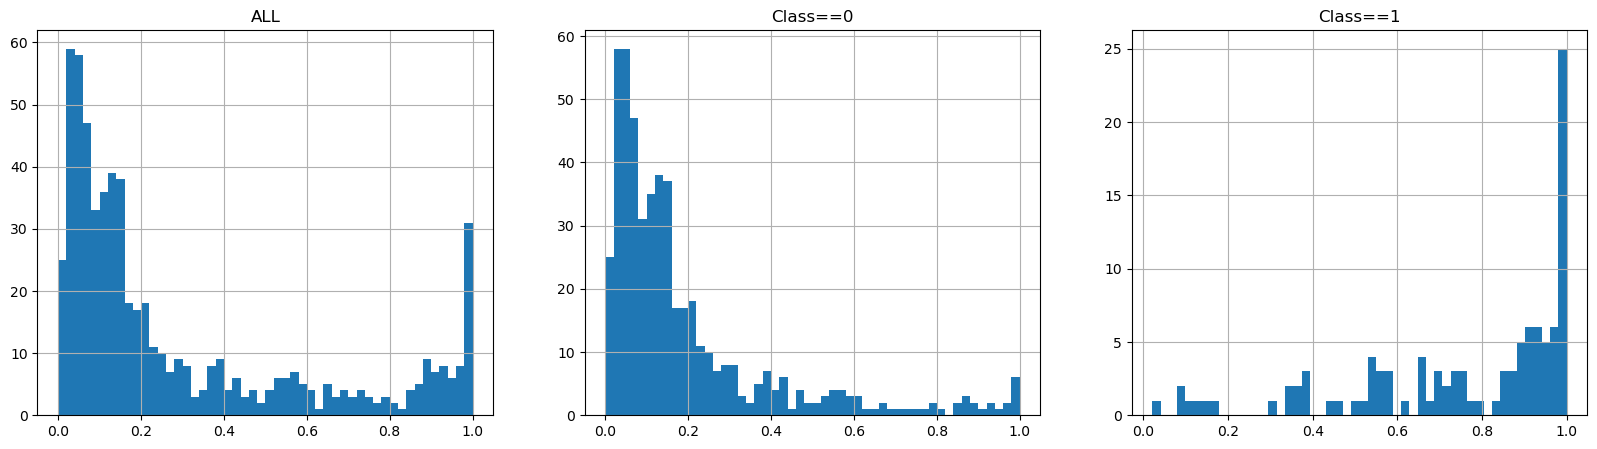

CV repeat nbr: 7 - metric: 0.3596


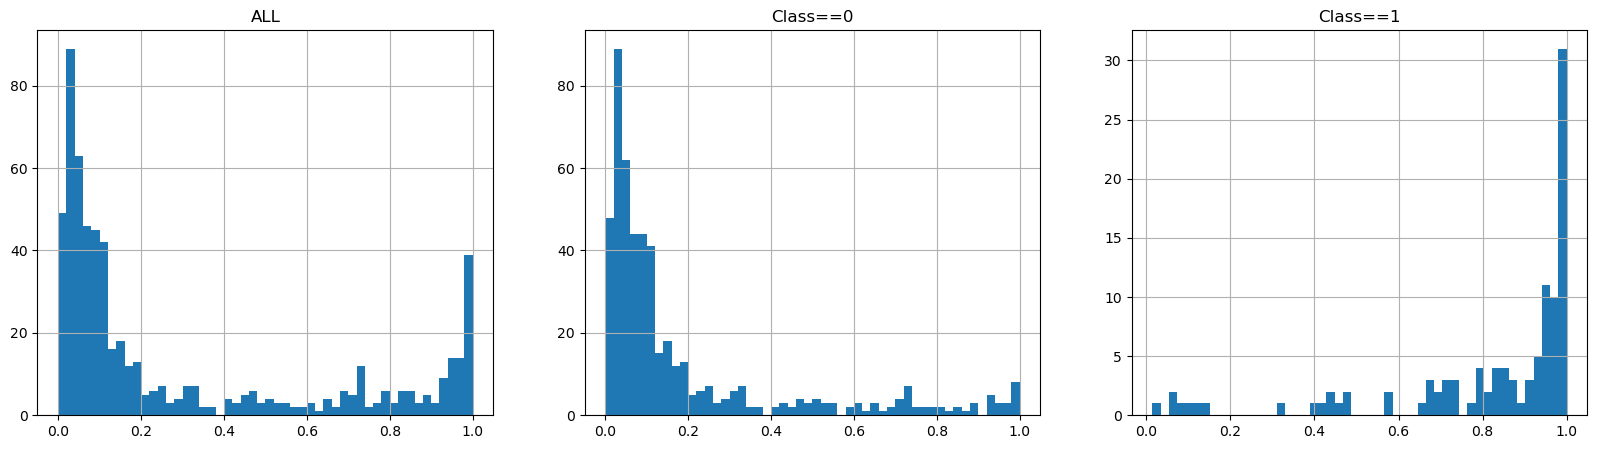

####################################################################################################
CV repeat nbr: 8 - metric: 0.3747


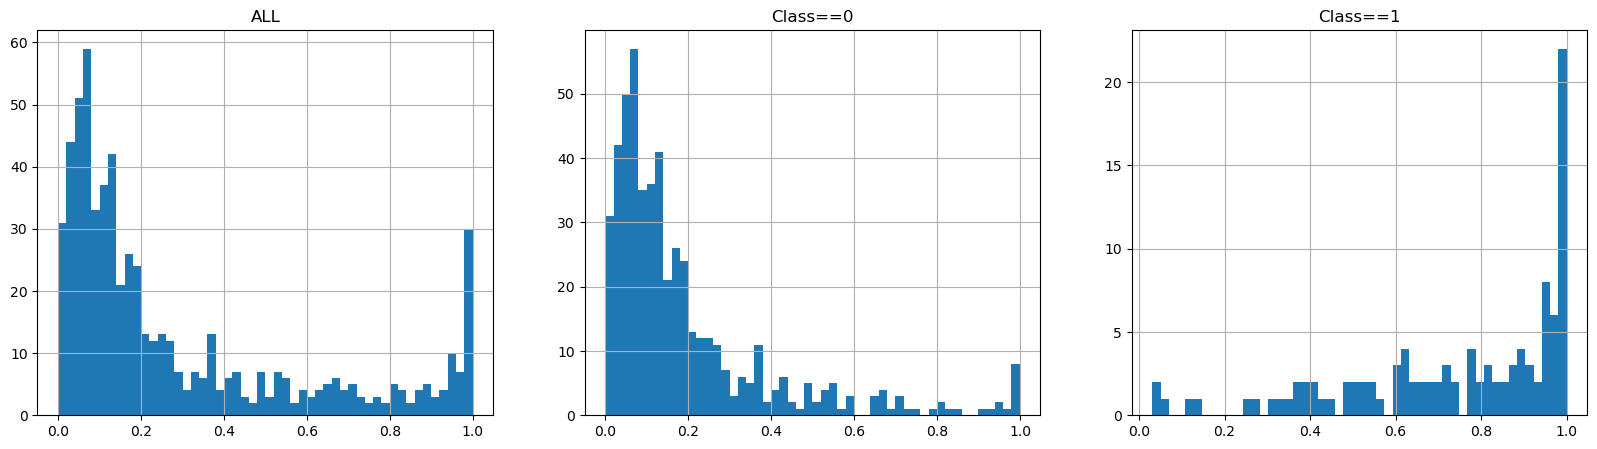

CV repeat nbr: 8 - metric: 0.3566


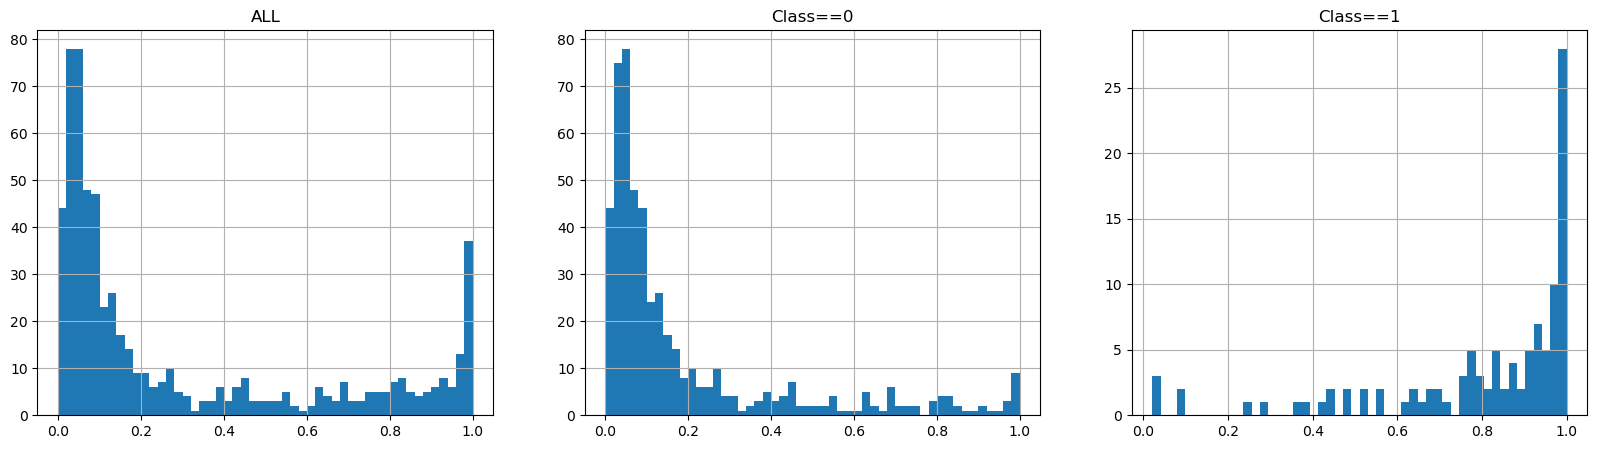

####################################################################################################
CV repeat nbr: 9 - metric: 0.3910


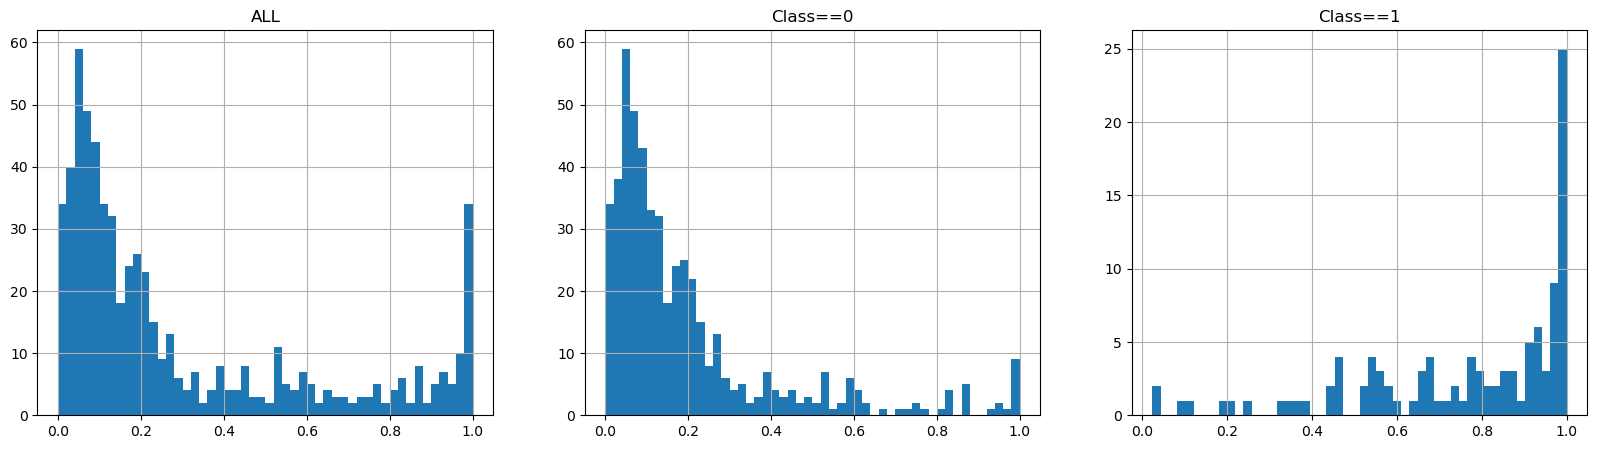

CV repeat nbr: 9 - metric: 0.3793


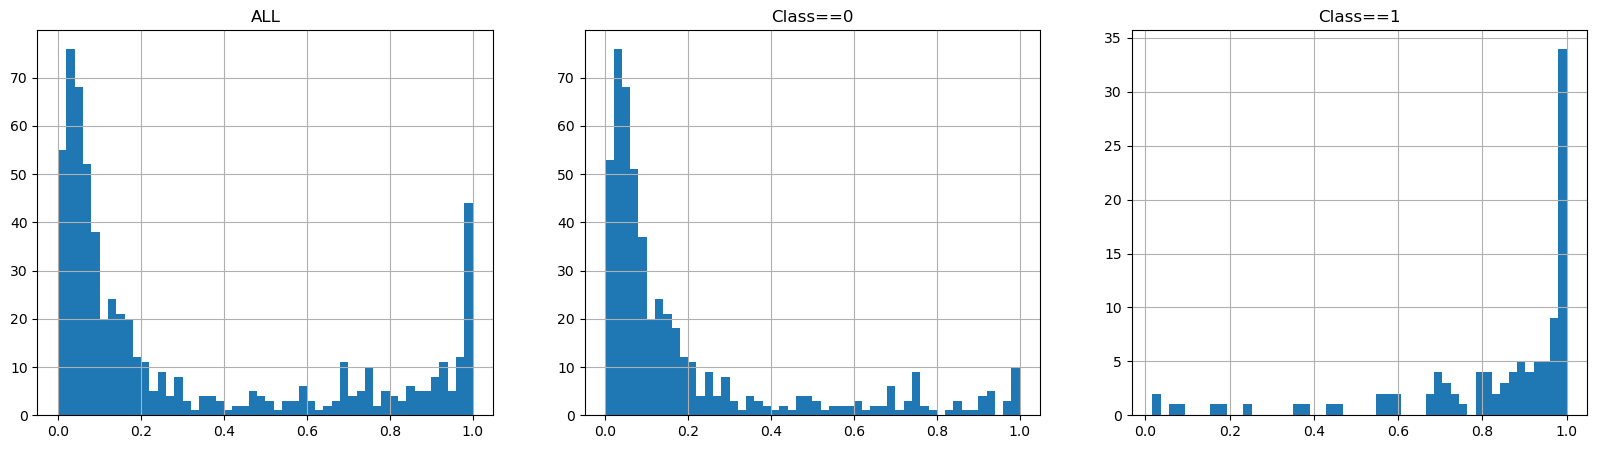

####################################################################################################
CV repeat nbr: 10 - metric: 0.3742


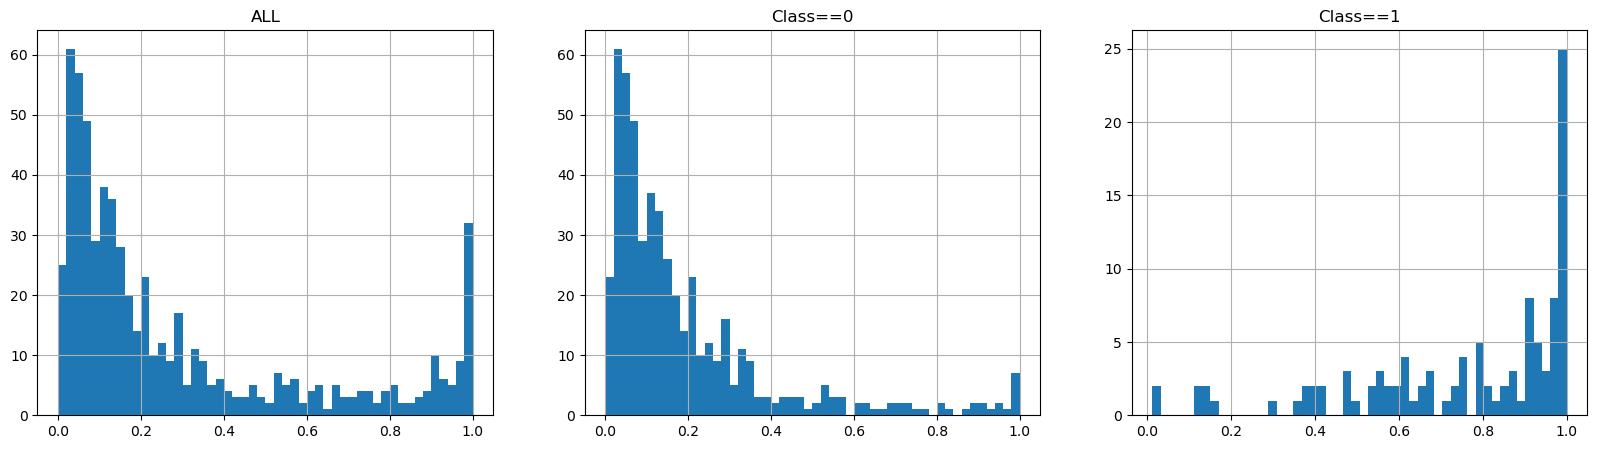

CV repeat nbr: 10 - metric: 0.3610


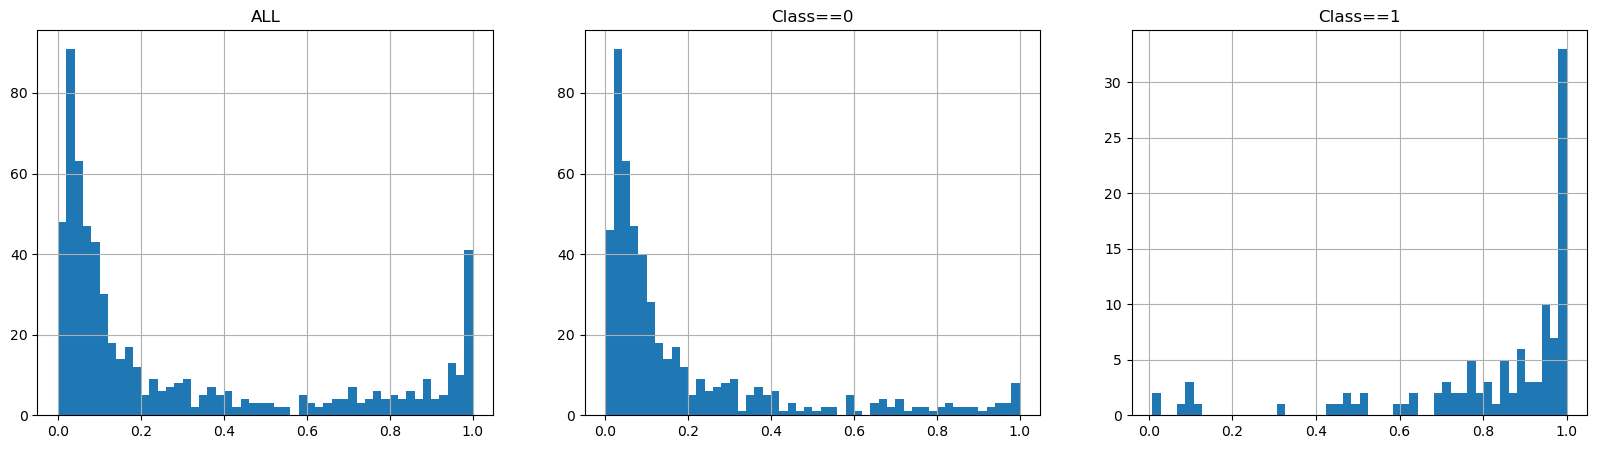

In [12]:
for i,oof in enumerate(oof_dfs):
    print("#"*100)
    oof = oof.copy(deep=True)
    
    metric = balanced_logloss_(oof.pred_proba.values, oof.Class.values)
    print(f"CV repeat nbr: {i+1} - metric: {metric:0.4f}")

    plt.figure(figsize=(20,5))

    plt.subplot(1,3,1)
    plt.title("ALL")
    oof.pred_proba.hist(bins=50)

    plt.subplot(1,3,2)
    plt.title("Class==0")
    oof.query("Class==0").pred_proba.hist(bins=50)

    plt.subplot(1,3,3)
    plt.title("Class==1")
    oof.query("Class==1").pred_proba.hist(bins=50)

    plt.show()
    
    calib_p1 = calibrate_probs(
        oof.pred_proba.values,
        **calib_params
    )
    oof["pred_proba"] = calib_p1
    
    metric = balanced_logloss_(oof.pred_proba.values, oof.Class.values)
    print(f"CV repeat nbr: {i+1} - metric: {metric:0.4f}")

    plt.figure(figsize=(20,5))

    plt.subplot(1,3,1)
    plt.title("ALL")
    oof.pred_proba.hist(bins=50)

    plt.subplot(1,3,2)
    plt.title("Class==0")
    oof.query("Class==0").pred_proba.hist(bins=50)

    plt.subplot(1,3,3)
    plt.title("Class==1")
    oof.query("Class==1").pred_proba.hist(bins=50)

    plt.show()

***
# inference

In [13]:
predicted_probs = [
    model.predict(xgb.DMatrix(test[input_cols]))
    for model in models
]
predicted_probs = np.mean(predicted_probs, axis=0)
predicted_probs

array([0.51642096, 0.51642096, 0.51642096, 0.51642096, 0.51642096],
      dtype=float32)

In [14]:
predicted_probs = calibrate_probs(predicted_probs, **calib_params)
predicted_probs = np.clip(predicted_probs, a_min=1e-7, a_max=1-1e-7)
predicted_probs

array([0.6654514, 0.6654514, 0.6654514, 0.6654514, 0.6654514],
      dtype=float32)

In [15]:
sub = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")
sub["class_0"] = 1-predicted_probs
sub["class_1"] = predicted_probs
sub.to_csv("submission.csv", index=False)
sub.describe()

,class_0,class_1
count,5.000000,5.000000
mean,0.334549,0.665451
std,0.000000,0.000000
min,0.334549,0.665451
25%,0.334549,0.665451
50%,0.334549,0.665451
75%,0.334549,0.665451
max,0.334549,0.665451


***
## save artifacts


In [16]:
joblib.dump(models, "models.pkl")
joblib.dump(oof_dfs, "oof_dataframes.pkl")
oof_scores.to_csv("oof_scores.csv", index=False)
joblib.dump(scaler, "scaler.pkl")
joblib.dump(calib_params, "calib_params.pkl")

['calib_params.pkl']

***